# ADS project 

## Introduction 

In this report, I will be analysing 2 different ways of calculating the similarity of documents (bags) of words. I will use some test text to create 20 documents of 100 words each. These 20 documents will be used to test 2 similarity measures, Jaccard similarity and Cosine similarity, for thier computation time as the documents increase in size (worst case running time). In addition, I will analyse the difference in running time between using a dictionary (sparse representation) and a vector (dense representation) to count word frequencies, and the differences in these when computing many pairs of documents at once.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import scipy.stats as stats

# The modules I will need in this report 

I will start by creating 2000 words of text using an online random text generator (https://randomtextgenerator.com/), and then split this up into a list of 20 lists with 100 words each. 

In [2]:
myfile = 'test_text.txt'
with open('test_text.txt', 'r') as file:
    test_text = file.read().replace('.','').lower()

# Split text into a list of words.    
test_list = test_text.split()

# Created a list of strings with 2000 words in.
print(len(test_list))

2000


In [3]:
# Make a function to split the list of text into n lists
def split_list(list_1, n):
    for i in range(0, len(list_1), n):
        yield list_1[i:i + n]

# Now I have a list , containing 20 lists, each containing 100 words.
list_of_docs = list(split_list(test_list, 100))

Now I will convert these lists into dictionaries, where each dictionary will act as a frequency table where the keys of the dictionary are the words, and the values will be the frequency at which these words occur. I will create a function to do this.

In [4]:
# Make a function to create a dictionary of frequency of words in a list 
def frequency_dict(word_list):
    dict_1={}
    for word in word_list:
        if word in dict_1:
            dict_1[word]+=1
        else:
            dict_1[word]=1
    return dict_1

# Convert the lists into dictionaries
list_of_dicts=[]
for list_1 in list_of_docs:
    list_of_dicts.append(frequency_dict(list_1))
    
print(list_of_dicts[0])

{'up': 1, 'am': 1, 'intention': 1, 'on': 1, 'dependent': 2, 'questions': 1, 'oh': 2, 'elsewhere': 1, 'september': 1, 'no': 2, 'betrayed': 1, 'pleasure': 2, 'possible': 1, 'jointure': 1, 'we': 2, 'in': 2, 'throwing': 1, 'and': 1, 'can': 1, 'event': 1, 'rapid': 1, 'any': 1, 'shall': 1, 'woman': 1, 'green': 1, 'hope': 1, 'they': 1, 'dear': 1, 'who': 2, 'its': 2, 'bred': 1, 'smiling': 1, 'nothing': 1, 'affixed': 1, 'he': 2, 'carried': 1, 'it': 2, 'clothes': 1, 'calling': 1, 'something': 1, 'disposing': 1, 'departure': 1, 'she': 3, 'favourite': 1, 'tolerably': 1, 'engrossed': 1, 'truth': 1, 'short': 1, 'folly': 1, 'court': 1, 'why': 1, 'their': 1, 'balls': 1, 'excellence': 1, 'put': 1, 'unaffected': 1, 'reasonable': 1, 'mrs': 1, 'introduced': 1, 'conviction': 1, 'nay': 2, 'particular': 1, 'delightful': 1, 'but': 1, 'unpleasant': 1, 'for': 1, 'uncommonly': 1, 'kept': 1, 'sent': 1, 'gave': 1, 'feel': 1, 'will': 1, 'has': 1, 'procured': 1, 'men': 1, 'laughing': 1, 'shutters': 1, 'old': 1, 'ins

In addition to needing a test sample to work  with, I will be needing a function to time other functions, I will create this function below. 

In [5]:
def timeit(somefunc,*args,repeats=1000,**kwargs):
    times=[]
    while repeats>0:
        starttime=time.time()
        ans=somefunc(*args,**kwargs)
        endtime=time.time()
        timetaken=endtime-starttime
        times.append(timetaken)
        repeats-=1
    mean=np.mean(times)
    stdev=np.std(times)
    error=stdev/(len(times)**0.5)
    return (ans, mean,error)

The timeit function takes another function, times how long it takes to run, and then adds that time to a list. It will repeat this 1000 times (unless repeats is changed form 1000) and take the mean of those times to find an accurate representation of the real time taken.

##  (1) Jaccard similarity 

The Jaccard similarity measure is one of many ways of calculating the similarity of 2 bags of words. It is calculated as follows:

$ J(A,B) = \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A| + |B| + |A \cap B|} $ 

Where $A$ and $B$ are both documents, $|A|$ and $|B|$ are the total amount of words in A and B respectively, and $|A \cap B|$ is the intersection, which is the amount of words that occour in both in A and B.

Now I will create a function to calculate the Jaccard similarity of 2 bags of words. To do this I also require a sperate function to calculate the total amount of words in a document (dictionary). 

In [6]:
#My function to caluclate the total words in a dictionary.
def total_dict(dict_1):
    a=0
    for b in dict_1:
        a += dict_1[b]
    return a

def jaccard(dict_1,dict_2):
    intersection={}
    for a in dict_1.keys():
        if a in dict_2.keys():
            intersection[a]=min(dict_1[a],dict_2[a])
           
    intersectiontot=total_dict(intersection)
    union = total_dict(dict_1) + total_dict(dict_2)-intersectiontot
    return intersectiontot/union

jaccard_1st_pair = jaccard(list_of_dicts[0],list_of_dicts[1])

print('The Jaccard similarity of the first pair of documents is:', jaccard_1st_pair)

The Jaccard similarity of the first pair of documents is: 0.10497237569060773


Now I want to test this function to find the worst case running time. To do this I will create a new function to create dictionaries of different word counts n, then I will create 10 pairs of dictionaries using this function, and append these pairs to a list. The first pair will be 2 dictionaries both with 100 words in each (frequencies will add up to 100), then the next pair will have 200 words each, then 300, and so on until the last pair will be 2 dictionaries of 1000 words in each dictionary. 

In [140]:
# Make larger dictionaries to test the worst case, make a function to split list into n dictionaries
def make_dict_n(list_1,n):
    list_of_docs = list(split_list(list_1, n))
    list_of_dicts=[]
    for list_2 in list_of_docs:
        list_of_dicts.append(frequency_dict(list_2))
    return list_of_dicts

test_samples = []
for n in range(100,1100,100):
    list_of_dicts_new = make_dict_n(test_list,n)
    test_samples.append([list_of_dicts_new[0],list_of_dicts_new[1]])

# Now my test_samples is a list of 10 lists, each containing 2 different dictionaries of the same word count, 

print('First pair of test samples (2 dictionaries with 100 words in each): \n\n', test_samples[0][0], '\n\n', test_samples[0][1],'\n\n', 
      'Second pair of test samples (2 dictionaries with 200 words in each):\n\n', test_samples[1][0],'\n\n', test_samples[1][1])

First pair of test samples (2 dictionaries with 100 words in each): 

 {'up': 1, 'am': 1, 'intention': 1, 'on': 1, 'dependent': 2, 'questions': 1, 'oh': 2, 'elsewhere': 1, 'september': 1, 'no': 2, 'betrayed': 1, 'pleasure': 2, 'possible': 1, 'jointure': 1, 'we': 2, 'in': 2, 'throwing': 1, 'and': 1, 'can': 1, 'event': 1, 'rapid': 1, 'any': 1, 'shall': 1, 'woman': 1, 'green': 1, 'hope': 1, 'they': 1, 'dear': 1, 'who': 2, 'its': 2, 'bred': 1, 'smiling': 1, 'nothing': 1, 'affixed': 1, 'he': 2, 'carried': 1, 'it': 2, 'clothes': 1, 'calling': 1, 'something': 1, 'disposing': 1, 'departure': 1, 'she': 3, 'favourite': 1, 'tolerably': 1, 'engrossed': 1, 'truth': 1, 'short': 1, 'folly': 1, 'court': 1, 'why': 1, 'their': 1, 'balls': 1, 'excellence': 1, 'put': 1, 'unaffected': 1, 'reasonable': 1, 'mrs': 1, 'introduced': 1, 'conviction': 1, 'nay': 2, 'particular': 1, 'delightful': 1, 'but': 1, 'unpleasant': 1, 'for': 1, 'uncommonly': 1, 'kept': 1, 'sent': 1, 'gave': 1, 'feel': 1, 'will': 1, 'has': 1

Now I have my test samples of increasing size, I can now find the average time taken to compute each pair of dictionaries, and then plot the relationship. My x values will be the word count in the dictionaries, and my y values will be the time taken to compute.

In [141]:
x_values = []
for n in range(100,1100,100):
    x_values.append(n)

y_values_j = []
for i in range(0,10):
    first_doc = test_samples[i][0]
    second_doc = test_samples[i][1]
    (ans, mean,error) = timeit(jaccard, first_doc, second_doc)
    y_values_j.append(mean)
    
print(x_values)    
print(y_values_j)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[2.698230743408203e-05, 5.796027183532715e-05, 7.194924354553222e-05, 9.892797470092774e-05, 0.00012391281127929686, 0.00014200806617736816, 0.00016188669204711913, 0.00018586850166320802, 0.00021084928512573242, 0.00023283791542053222]


Now I have my values, I can plot these against each other on a scatter graph to view the relationship to calculate a time complexity.

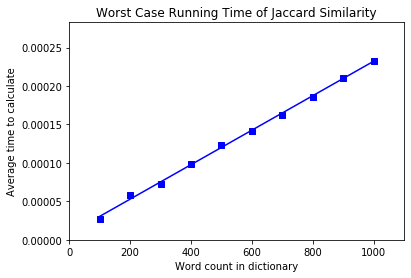

In [142]:
%matplotlib inline
z = np.polyfit(x_values,y_values_j, 1)
p = np.poly1d(z)
plt.plot(x_values, p(x_values), c='b')
plt.scatter(x_values,y_values_j, c='b', marker="s",)
plt.ylim(0,max(y_values_j)+0.00005)
plt.xlim(0,1100)
plt.xlabel("Word count in dictionary")
plt.ylabel("Average time to calculate")
plt.title("Worst Case Running Time of Jaccard Similarity")
plt.show()

#### How to calculate time complexity 

If $y=c_a.x^n$ then it follows that: $$\log(y) = \log(c_a) + n \log(x)$$
The values for $n$ and $c_a$ can be found if we plot a graph of $\log(y)$ against $\log(x)$, the gradient (slope) will be $n$ and the $y$-intercept will be $\log(c_a)$

As our graph for the jaccard time complexity looks like it  is linear (straight line), we should expect our value for $n$ to be close to 1, thus making our Big-O notation O(n) (approximately $y=c_a.x$) for the jaccard similarity.

Below I will take the log of my x and y values and plot them against each other.

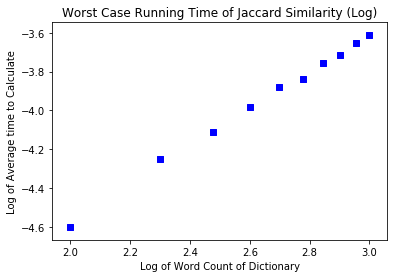

In [10]:
log_x_values=[np.log10(x) for x in x_values]
log_y_values_j=[np.log10(y) for y in y_values_j]

plt.scatter(log_x_values,log_y_values_j, c='b', marker="s",)
plt.xlabel("Log of Word Count of Dictionary")
plt.ylabel("Log of Average time to Calculate")
plt.title("Worst Case Running Time of Jaccard Similarity (Log)")
plt.show()

Now I have my log values, I can calculate the gradient (slope) and y-intercept to find my $c_a$ and $n$. 

In [143]:
# finding the slope, intercept, and constant for the jaccard worst case

slope, intercept = np.polyfit(log_x_values,log_y_values_j,1) 
print('Slope n = ', slope )
print('Intercept = ', intercept)
constant = 10**intercept 
print('Constant: c = ', constant)

Slope n =  0.9690794786088619
Intercept =  -6.513881237782978
Constant: c =  3.0628008730475924e-07


Above we have our values for $c_a$ and $n$. (on my computer it was $c_a = 3.529x10^{-0.7}$ and $n = 0.942$ but the constant will vary depending on the computer used to run this document).

## (2) Cosine Similarity (Dense Representation)

Now I will repeat this process of calculating worst case running time for a new similarity measure, the Cosine measure. However, this time I will not be using a dictionary (sparse representation) to represent the bags of words, instead I will use a vector (dense representation) for each document, which will become a matrix for all 20 documents.

I will create a function to convert my dictionaries into vectors below.

In [145]:
def dense_rep(list_of_dicts):
    allfeatures={}    
    for docdict in list_of_dicts:
        for feat in docdict.keys():
            allfeatures[feat]=1
    
    dimensions=list(allfeatures.keys())
    sorted(dimensions)
    
    matrix=[]
    for dimension in dimensions:
        row=[]
        for docdict in list_of_dicts:
            row.append(docdict.get(dimension,0))
        matrix.append(row)
        
    return matrix

def transpose(matrix):
    transposed=[]
    for i in range(0,len(matrix[0])):
        transposed.append([row[i] for row in matrix])   
    return transposed

word_matrix = dense_rep(list_of_dicts)
doc_vectors=transpose(word_matrix)
print('The first function produces vectors like this: \n', word_matrix[0], '\n') 
print('The second function produces vectors like this:\n',doc_vectors[0])

# Using these 2 functoins (in this order) will convert my bags from dictionary form (sparse representation) 
# to vector form (dense representation), which we will then Use to calculate the cosine similarity

The first function produces vectors like this: 
 [1, 0, 1, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0] 

The second function produces vectors like this:
 [1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Above I have made the 2 functions needed to convert sparse representation into dense representation. The first function creates a vector for every word in the whole 2000 words, with the rows of these vectors being the frequency at which that specific word occurs in every document (the first vector printed above). The second will convert these vectors representing words into vectors representing individual documents, with the rows being the frequency at which each word occurs in that document. Now I have the documents represented correctly, I can now make a function to calculate the Cosine similarity. 

#### How cosine similarity is calculated.

The Cosine similarity of 2 vectors is calculated as follows:

${\displaystyle \cos(A,B)={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}},}$

Where $A$ and $B$ are 2 documents, $||A||$ and $||B||$ are the norms of $A$ and $B$, and $\mathbf {A} \cdot \mathbf {B}$ is the dot product of $A$ and $B$.

I will require 2 functions to calculate Cosine similarity, one to calculate the dot product of 2 vectors, and one to calculate cosine similarity using that dot product function. 

In [146]:
def dot_product(vector_1,vector_2):
    dot=0
    for i in range(0,len(vector_1)):
        dot+=vector_1[i]*vector_2[i]
    return dot

def cosine(vector_1,vector_2):
    return dot_product(vector_1,vector_2)/math.sqrt(dot_product(vector_1,vector_1)*dot_product(vector_2,vector_2))


cosine_1st_pair = cosine(doc_vectors[0],doc_vectors[1])
print('The cosine similarity of the first 2 documents is', cosine_1st_pair)

The cosine similarity of the first 2 documents is 0.22225022225033336


Now that I have my documents in dense representation and I have a function to calculate the similarity, I can find the worst case running time and the corresponding time complexity function. I will use the same test samples I used when testing the Jaccard similarity worst case, but converted into vector form first. 

In [14]:
y_values_cd = []
for i in range(0,10):
    dense_r = dense_rep(test_samples[i])
    trans_dense = transpose(dense_r)    #Converting the test samples into dense representation.
    v1 = trans_dense[0]
    v2 = trans_dense[1]
    (ans, mean,error) = timeit(cosine, v1, v2) 
    y_values_cd.append(mean)
    
print(y_values_cd)

[5.19564151763916e-05, 9.893035888671875e-05, 0.00015988826751708984, 0.00017787599563598634, 0.00021784424781799317, 0.0002488250732421875, 0.0002738063335418701, 0.0002937924861907959, 0.0003087825775146484, 0.00033176612854003907]


Now to plot these results.

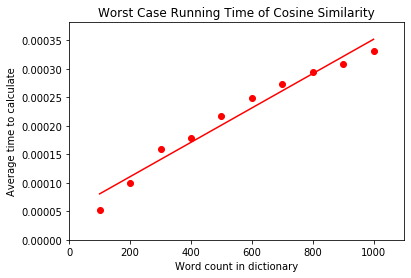

In [15]:
%matplotlib inline
z = np.polyfit(x_values,y_values_cd, 1)
p = np.poly1d(z)
plt.plot(x_values, p(x_values), c='r')
plt.scatter(x_values,y_values_cd, c='r', marker="o")
plt.xlim(0,1100)
plt.ylim(0,max(y_values_cd)+0.00005)
plt.xlabel("Word count in dictionary")
plt.ylabel("Average time to calculate")
plt.title("Worst Case Running Time of Cosine Similarity")
plt.show()

Now I have the worst case running time for the Cosine measure. It clearly has a steaper gradient compared to the Jaccard measure, as the times taken increase faster. Also, it doesn't look as linear as the worst case for Jaccard, so it may not have the same form of time complexity function. But for now I will assume it does, and calculate the slope and intercept of the log function.

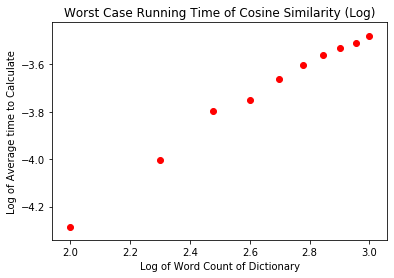

Slope =  0.7946121714481154
Intercept =  -5.828979902824791
Constant: C =  1.4825866909338113e-06


In [16]:
log_y_values_cd=[np.log10(y) for y in y_values_cd]

plt.scatter(log_x_values,log_y_values_cd,c='r', marker="o")
plt.xlabel("Log of Word Count of Dictionary")
plt.ylabel("Log of Average time to Calculate")
plt.title("Worst Case Running Time of Cosine Similarity (Log)")
plt.show()

# finding the slope, intercept, and constant for the cosine worst case

slope_cd, intercept_cd = np.polyfit(log_x_values,log_y_values_cd,1)
print('Slope = ', slope_cd )
print('Intercept = ', intercept_cd)
constant_cd = 10**intercept_cd 
print('Constant: C = ', constant_cd)

This has given a slope that is less than the jaccard's slope, which is not what we expected. This suggests that this is not the correct time complexity, and could mean that this algorithm has the big O notation of $O(nlogn)$ with the complexity function $y = c_b.nlog(n)$.

If this is the case then if we plot the graph of our $y$ values against $t=xlog(x)$, then we should get a y intercept very close to 0, and a gradient of $c_b$.

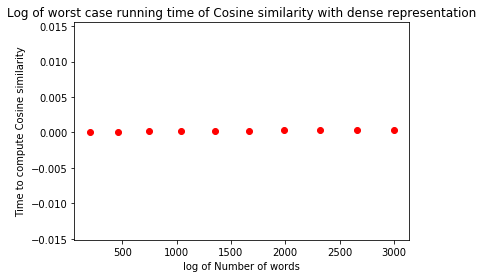

Intercept: 6.890824836133398e-05, Slope: C = 9.553211248740696e-08


In [17]:
nlogx_values=[x*np.log10(x) for x in x_values]
plt.scatter(nlogx_values,y_values_cd, c='r')
plt.xlabel("log of Number of words")
plt.ylabel("Time to compute Cosine similarity")
plt.title("Log of worst case running time of Cosine similarity with dense representation")
plt.show()
slope, intercept, r_value, p_value, std_err = stats.linregress(nlogx_values, y_values_cd)
print("Intercept: {}, Slope: C = {}".format(intercept, slope))

As this graph produced a flat line with a gradient close to 0, it proves this algorithmn has the notation $O(nlog(n))$ with the time complexity function $y = c_b.nlogn(n)$ with $c_b$ defined above as the slope C (on my computer $c_b=9.585x10^{-8}$)

#### Cosine similarity using numpy's dot product

In addition to testing the previous function for calculating Cosine similarity using dense representation, I also want to test the time complexity of using the numpy function for calculating the dot product, compared to my own dot product function. I will make a function incorporating the numpy dot product below.

In [18]:
# Now to see the difference between using my own dot product function, and using the numpy dot product function to calculate 
# Cosine similarity 

def cosine_np(vector_1,vector_2):
    return np.dot(vector_1,vector_2)/math.sqrt(np.dot(vector_1,vector_1)*np.dot(vector_2,vector_2))

cosine_np(doc_vectors[0], doc_vectors[1])

0.22225022225033336

Now I will use the same methods as before to find the worst case running time of this new Cosine function.

In [19]:
y_values_cd2 = []
for i in range(0,10):
    dense_r = dense_rep(test_samples[i])
    trans_dense = transpose(dense_r)
    v1 = trans_dense[0]
    v2 = trans_dense[1]
    (ans, mean,error) = timeit(cosine_np, v1, v2)
    y_values_cd2.append(mean)
    
print(y_values_cd2)

[0.00011591839790344238, 0.00018487167358398438, 0.0002548203468322754, 0.0002967958450317383, 0.00035974955558776853, 0.00040402507781982423, 0.0004399588108062744, 0.00046303153038024903, 0.0004949922561645508, 0.0005239083766937256]


Now to plot these times.

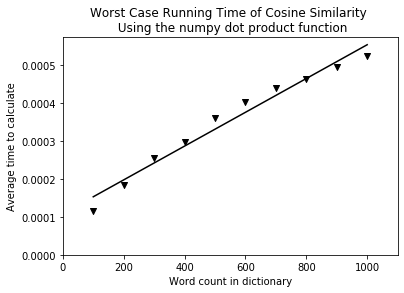

In [20]:
# Now to plot these values against each other in a scatter graph

%matplotlib inline
z = np.polyfit(x_values,y_values_cd2, 1)
p = np.poly1d(z)
plt.plot(x_values, p(x_values), c='k')
plt.scatter(x_values, y_values_cd2,c='k', marker="v")
plt.xlim(0,1100)
plt.ylim(0,max(y_values_cd2)+0.00005)
plt.xlabel("Word count in dictionary")
plt.ylabel("Average time to calculate")
plt.title("Worst Case Running Time of Cosine Similarity \n Using the numpy dot product function")
plt.show()

This looks like the slowest algorithm so far (ranges from 0.0001 to 0.0005) and it clearly has a larger gradient than the other 2. Thus if this is the standard complexity notation of O(n), we should expcect the gradient of the log to be higher than the Jaccards. 

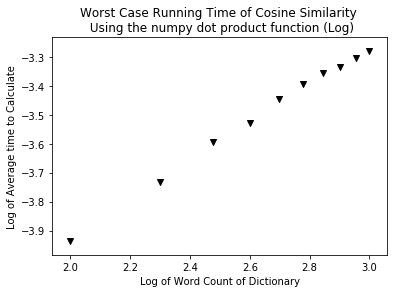

Slope =  0.6620207129970532
Intercept =  -5.248811367702591
Constant: C =  5.638825204589933e-06


In [21]:
log_y_values_cd2=[np.log10(y) for y in y_values_cd2]

plt.scatter(log_x_values,log_y_values_cd2,c='k', marker="v")
plt.xlabel("Log of Word Count of Dictionary")
plt.ylabel("Log of Average time to Calculate")
plt.title("Worst Case Running Time of Cosine Similarity \n Using the numpy dot product function (Log)")
plt.show()

# finding the slope, intercept, and constant for the worst case

slope_cd2, intercept_cd2 = np.polyfit(log_x_values,log_y_values_cd2,1)
print('Slope = ', slope_cd2 )
print('Intercept = ', intercept_cd2)
constant_cd2 = 10**intercept_cd2 
print('Constant: C = ', constant_cd2)

The slope of this is even smaller than the last cosine function, which suggests this is likely to also have the big O notation $O(nlogn)$ with the time complexity function of $y = c_c.nlogn(n)$. I will test this below as I did before, to find the value of $c_c$.

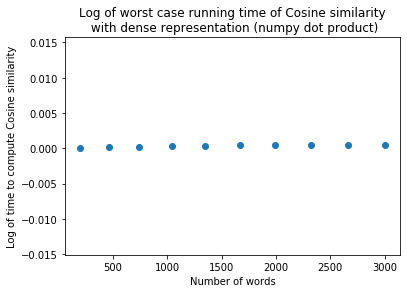

Intercept: 0.0001356839737937507, Slope: c = 1.4133191593899343e-07


In [22]:
plt.scatter(nlogx_values,y_values_cd2)
plt.xlabel("Number of words")
plt.ylabel("Log of time to compute Cosine similarity")
plt.title("Log of worst case running time of Cosine similarity\n with dense representation (numpy dot product)")
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(nlogx_values, y_values_cd2)
print("Intercept: {}, Slope: c = {}".format(intercept, slope))

Again we have a intercept very close to 0, which suggests this is the correct time complexity, and we have found a $c_c$ value of the slope c above (on my computer $c_c=1.406x10^{-7}$).

## (3) Cosine Similarity (Sparse representation)

Now I am going to create a new function, which will calculate the Cosine similarity of 2 documents straight from the sparse representation (dictionary form). I will again test this function to find its worst case running time. 

In [23]:
# Create a function to calculate the cosine similairy of 2 dictionaries (Sparse representaiton)

def cosine_sparse(dict_1,dict_2):
    intersection = 0
    dot_1 = 0
    dot_2 = 0
    for key_1,value_1 in dict_1.items():
        intersection += value_1*dict_2.get(key_1,0.0)
        dot_1 += value_1*value_1
    for value_2 in dict_2.values():
        dot_2 += value_2*value_2
    return intersection/math.sqrt(dot_1*dot_2)

# Both representations give the same cosine similarity value for our first pair

print('Cosine of first 2 documents with dense representation: ', cosine(doc_vectors[0], doc_vectors[1]))
print('Cosine of first 2 documents with sparse representation: ', cosine_sparse(list_of_dicts[0], list_of_dicts[1]))

Cosine of first 2 documents with dense representation:  0.22225022225033336
Cosine of first 2 documents with sparse representation:  0.22225022225033336


As this function gives me identical results to the previous cosine functions, I can asssume it works correctly. Now I will investigate its worst case running time.

In [24]:
y_values_cs = []
for i in range(0,10):
    first_doc = test_samples[i][0]
    second_doc = test_samples[i][1]
    (ans, mean,error) = timeit(cosine_sparse, first_doc, second_doc)
    y_values_cs.append(mean)
    
print(y_values_cs)

[3.097915649414063e-05, 5.416584014892578e-05, 7.694673538208008e-05, 0.00010100436210632324, 0.00012404537200927734, 0.00014096927642822266, 0.0001610262393951416, 0.00017587614059448242, 0.0001920039653778076, 0.00020685911178588867]


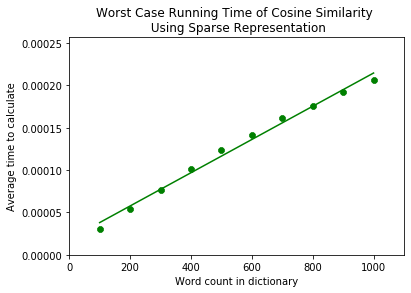

In [25]:
# Now to plot these values against each other in a scatter graph

%matplotlib inline
z = np.polyfit(x_values,y_values_cs, 1)
p = np.poly1d(z)
plt.plot(x_values, p(x_values), c='g')
plt.scatter(x_values,y_values_cs, c='g', marker="8")
plt.xlim(0,1100)
plt.ylim(0,max(y_values_cs)+0.00005)
plt.xlabel("Word count in dictionary")
plt.ylabel("Average time to calculate")
plt.title("Worst Case Running Time of Cosine Similarity \n Using Sparse Representation")
plt.show()

This algorithm is much faster and more linear than both of the previous cosine algorithms, thus suggesting this algorithm does have a time complexity notation of $O(n)$, and hence has a time complexity function of $y=c_d.x^n$ with $n$ close to 1. I will test this below. 

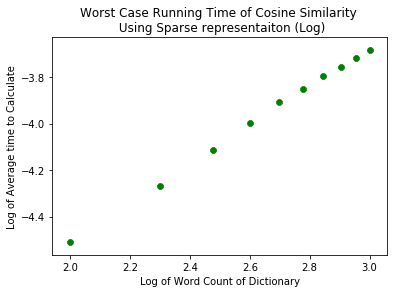

Slope =  0.8371220102265565
Intercept =  -6.182464335237154
Constant: C =  6.569550641673177e-07


In [26]:
log_y_values_cs=[np.log10(y) for y in y_values_cs]

plt.scatter(log_x_values,log_y_values_cs, c='g', marker="8")
plt.xlabel("Log of Word Count of Dictionary")
plt.ylabel("Log of Average time to Calculate")
plt.title("Worst Case Running Time of Cosine Similarity \n Using Sparse representaiton (Log)")
plt.show()

# finding the slope, intercept, and constant for the cosine worst case

slope_cs, intercept_cs = np.polyfit(log_x_values,log_y_values_cs,1)
print('Slope = ', slope_cs )
print('Intercept = ', intercept_cs)
constant_cs = 10**intercept_cs 
print('Constant: C = ', constant_cs)

This has given a gradient very close to that of the Jaccard measure, which suggests this is an accurate gradient as the 2 graphs look very similar. Thus I will assume this to be true, taking my value of $c_d$ = c, with c defined above (on my computer $c_c=6.531x10^{-7}$ and $n=0.836$)

#### All 4 algorithms 

Now I have found the worst case running times for 4 different algorithms for calculating the similarity of 2 bags of words, now I will plot these all against each other to see how they compare in running time.

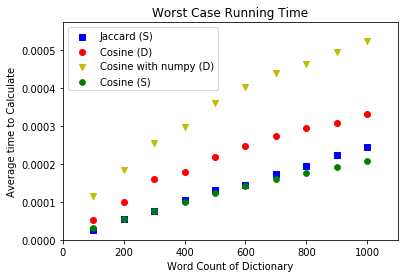

(D) = dense representation 
(S) = sparse representation


In [27]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x_values, y_values_j, c='b', marker="s", label='Jaccard (S)')
ax1.scatter(x_values,y_values_cd, c='r', marker="o", label='Cosine (D)')
ax1.scatter(x_values,y_values_cd2, c='y', marker="v", label='Cosine with numpy (D)')
ax1.scatter(x_values,y_values_cs, c='g', marker="8", label='Cosine (S)')
plt.xlim(0,1100)
plt.ylim(0,max(y_values_cd2)+0.00005)
plt.xlabel("Word Count of Dictionary")
plt.ylabel("Average time to Calculate")
plt.title("Worst Case Running Time")
plt.legend(loc='upper left');
plt.show()

print('(D) = dense representation \n(S) = sparse representation')

This graph clearly shows that the algorithms using dense representation are much slower than the 2 sparse measures, the algorithm using the numpy dot product being by far the slowest. This is to be expected as the 2 algorithms under $O(n)$ will run much faster (have a lower gradient) than the 2 functions with $O(nlogn)$ notation. 

## (4) All pairs function 

Below I have made a function that will compute the similarity of all pairs in a list of dictionaries up to the nth dictionary, using a specified similarity measure (Jaccard or Cosine). When first creating this function I attempted to include nclude the similarity checks for dense representations as well (cosine with and without using numpys dot product) but due to these having very large running times (5 to 10 minutes per cell) I decided to remove them for the function and only include the 2 sparse methods. 

Below I have printed 2 dictionaries where the keys are the pairs of documents (documents position in the list), and the value is the similarity of that pair. The first dictionary displays the similarities for the Jaccard measure, and the second displays the similarities for the Cosine measure.

In [28]:
def all_pairs_sim(dicts_list, sim_check, n):
    sim_dict = {}  
    if sim_check == jaccard or sim_check ==  cosine_sparse:
        for i in range(0,n):
            for j in range(0,n):
                if i!=j:
                    sim_dict[i+1,j+1] = sim_check(dicts_list[i], dicts_list[j])
    return sim_dict

all_pairs_sim(list_of_dicts, jaccard, 20)

{(1, 2): 0.10497237569060773,
 (1, 3): 0.09289617486338798,
 (1, 4): 0.0989010989010989,
 (1, 5): 0.07526881720430108,
 (1, 6): 0.05263157894736842,
 (1, 7): 0.1111111111111111,
 (1, 8): 0.07526881720430108,
 (1, 9): 0.09289617486338798,
 (1, 10): 0.07526881720430108,
 (1, 11): 0.0582010582010582,
 (1, 12): 0.0582010582010582,
 (1, 13): 0.08695652173913043,
 (1, 14): 0.07526881720430108,
 (1, 15): 0.07526881720430108,
 (1, 16): 0.09289617486338798,
 (1, 17): 0.07526881720430108,
 (1, 18): 0.0989010989010989,
 (1, 19): 0.04712041884816754,
 (1, 20): 0.08108108108108109,
 (2, 1): 0.10497237569060773,
 (2, 3): 0.12359550561797752,
 (2, 4): 0.13636363636363635,
 (2, 5): 0.0582010582010582,
 (2, 6): 0.0989010989010989,
 (2, 7): 0.0989010989010989,
 (2, 8): 0.10497237569060773,
 (2, 9): 0.1111111111111111,
 (2, 10): 0.11731843575418995,
 (2, 11): 0.08695652173913043,
 (2, 12): 0.08695652173913043,
 (2, 13): 0.12359550561797752,
 (2, 14): 0.08695652173913043,
 (2, 15): 0.11731843575418995,
 (

In [29]:
all_pairs_sim(list_of_dicts, cosine_sparse, 20)

{(1, 2): 0.22225022225033336,
 (1, 3): 0.18875299723585118,
 (1, 4): 0.21379652762353413,
 (1, 5): 0.20171788261496962,
 (1, 6): 0.13018891098082389,
 (1, 7): 0.2743363203563587,
 (1, 8): 0.13130643285972254,
 (1, 9): 0.22737714847156215,
 (1, 10): 0.16804840491192596,
 (1, 11): 0.158686362385502,
 (1, 12): 0.17751173670117326,
 (1, 13): 0.20343336780168375,
 (1, 14): 0.2047307562133314,
 (1, 15): 0.157485197087178,
 (1, 16): 0.19364916731037085,
 (1, 17): 0.13603918492870198,
 (1, 18): 0.26987526987540483,
 (1, 19): 0.12417490847484786,
 (1, 20): 0.16668766668775004,
 (2, 1): 0.22225022225033336,
 (2, 3): 0.25847697156146465,
 (2, 4): 0.32582623392466287,
 (2, 5): 0.1475608130513894,
 (2, 6): 0.2232091110858452,
 (2, 7): 0.2541325113662818,
 (2, 8): 0.2418010379123379,
 (2, 9): 0.23871592765805777,
 (2, 10): 0.28456225021325376,
 (2, 11): 0.19516771707436256,
 (2, 12): 0.2049455736824853,
 (2, 13): 0.3174144950046523,
 (2, 14): 0.22400716834408235,
 (2, 15): 0.2720087044178143,
 (2, 1

Now I will find the worst case running times for both of these measures when computing all pairs of an increasing amount of documents. I will start at 2 documents and add 2 more documents at a time, which I will time for both similarity measures and then plot against each other.

In [30]:
# Time to find the worst case running time for my all_pairs_sim function for the every similarity measure, first jaccard.
    
x_values_ap = []
for x in range(2,21,2):
    x_values_ap.append(x)

y_values_ap_j = []
for n in range(2,21,2):
    (ans, mean,error) = timeit(all_pairs_sim, list_of_dicts, jaccard, n)
    y_values_ap_j.append(mean)
    
print(y_values_ap_j)

[5.5959224700927736e-05, 0.0003287684917449951, 0.000784334659576416, 0.0014399597644805908, 0.002484101295471191, 0.0035306332111358645, 0.00502006196975708, 0.0063303494453430175, 0.008019614934921265, 0.009818196296691895]


In [31]:
y_values_ap_cs = []
for n in range(2,21,2):
    (ans, mean,error) = timeit(all_pairs_sim, list_of_dicts, cosine_sparse, n)
    y_values_ap_cs.append(mean)
    
print(y_values_ap_cs)

[6.395792961120606e-05, 0.0003474209308624268, 0.0008714091777801513, 0.0016339049339294434, 0.002622049331665039, 0.0038413007259368898, 0.005240822553634643, 0.006900035619735718, 0.008843973159790039, 0.011083195686340332]


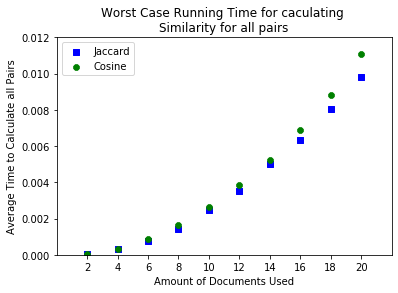

In [32]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(x_values_ap, y_values_ap_j, c='b', marker="s", label='Jaccard')
ax2.scatter(x_values_ap,y_values_ap_cs, c='g', marker="8", label='Cosine')
plt.xlim(0,22)
plt.ylim(0, 0.012)
plt.xticks(range(2,21,2))
plt.xlabel("Amount of Documents Used")
plt.ylabel("Average Time to Calculate all Pairs")
plt.title("Worst Case Running Time for caculating \nSimilarity for all pairs")
plt.legend(loc='upper left');
plt.show()

It appears that the Jaccard similarity test is slightly faster when calculating for all pairs of documents. Now I will calculate the time complexities for both measures. 

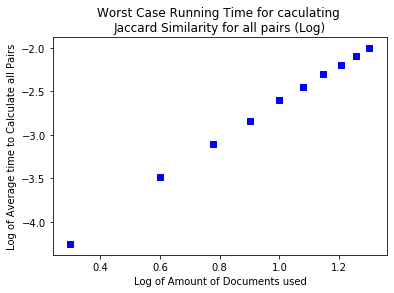

Slope: S =  2.224098775650648
Intercept =  -4.862580784291816
Constant: C =  1.3722056895728126e-05


In [33]:
# Now to find the time complexities, first for the Jaccard similarity of all pairs.

log_x_values_ap=[np.log10(x) for x in x_values_ap]
log_y_values_ap_j=[np.log10(y) for y in y_values_ap_j]

plt.scatter(log_x_values_ap,log_y_values_ap_j, c='b', marker="s")
plt.xlabel("Log of Amount of Documents used")
plt.ylabel("Log of Average time to Calculate all Pairs")
plt.title("Worst Case Running Time for caculating \nJaccard Similarity for all pairs (Log)")
plt.show()

# finding the slope, intercept, and constant for the cosine worst case

slope_ap_j, intercept_ap_j = np.polyfit(log_x_values_ap,log_y_values_ap_j,1)
print('Slope: S = ', slope_ap_j )
print('Intercept = ', intercept_ap_j)
constant_ap_j= 10**intercept_ap_j 
print('Constant: C = ', constant_ap_j)

The slope and intercept of the log graph shows us that the time complexity for calculating all pairs for the Jaccard similarity is:

$ y = Cx^S $. with C and S defined above. 

To calculate how long it would take to calculate the Jaccard similarity for 200,000 documents, we need to put $x=200,000$ into our equation.

In [34]:
yj_200k = constant_ap_j*(200000)**(slope_ap_j)
yj_200k_days = ((yj_200k/60)/60)/24
print('It will take', yj_200k_days, 'days to compute the Jaccard similarity of 200k documents of 200 words in each')

It will take 97.93091139096528 days to compute the Jaccard similarity of 200k documents of 200 words in each


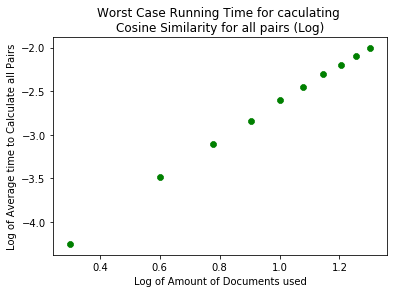

Slope: S =  2.2146085984539705
Intercept =  -4.814106212227524
Constant: C =  1.534241718628791e-05


In [35]:
# Now to caluculate the time complexity for the Cosine similarity of all pairs.

log_x_values_ap=[np.log10(x) for x in x_values_ap]
log_y_values_ap_cs=[np.log10(y) for y in y_values_ap_cs]

plt.scatter(log_x_values_ap,log_y_values_ap_j, c='g', marker="8")
plt.xlabel("Log of Amount of Documents used")
plt.ylabel("Log of Average time to Calculate all Pairs")
plt.title("Worst Case Running Time for caculating \nCosine Similarity for all pairs (Log)")
plt.show()

# finding the slope, intercept, and constant for the cosine worst case

slope_ap_cs, intercept_ap_cs = np.polyfit(log_x_values_ap,log_y_values_ap_cs,1)
print('Slope: S = ', slope_ap_cs )
print('Intercept = ', intercept_ap_cs)
constant_ap_cs= 10**intercept_ap_cs
print('Constant: C = ', constant_ap_cs)

The time complexity for calculating all pairs for the Cosine similarity is:

$ y = Cx^S $. with C and S defined above. 

Again, to find the Cosine similarity for all pairs of 200,000 documents, we need to put $x=200,000$ into our equation.

In [36]:
yc_200k = constant_ap_cs*(200000)**(slope_ap_cs)
yc_200k_days = ((yc_200k/60)/60)/24
print('It will take', yc_200k_days, 'days to compute the Cosine similarity of 200k documents of 200 words in each')

It will take 97.51841958560959 days to compute the Cosine similarity of 200k documents of 200 words in each


## (5) Map-Reduce Computing Paradigm (incomplete)

#### What is the Map-Reduce paradigm?

The Map-Reduce computing paradigm was created to attempt to split up the work load of an algorithm to decrease the runing time. Map-Reduce has two main parts - map and reduce. The input data is split up into small 'chunks', which is given to the map which takes these chunks to return a key-value pair. The key-value pairs given by the seperate mapper functions are shuffled up and sorted. These are then passed onto the reduce processes, which take these key-value pairs and returns the new key-value pairs, which is the output. 

I have attempted to implement this into my all_pairs_sim function, but I was unable to do this, and have insted only managed this to calculate 1 pair.

In [137]:
from multiprocessing import Pool
from collections import defaultdict
import defs

def map_reduce_parallel(inputs,mapper,reducer,mapprocesses=3,reduceprocesses=2):
    
    collector=defaultdict(list)  
    mappool = Pool(processes=mapprocesses)
    mapresults=mappool.map(mapper,inputs)
    mappool.close()
    #print(len(mapresults[0]), mapresults, '\n')
    for mapresult in mapresults:
        for (key, value) in mapresult:     
            collector[key].append(value)     
    #print(collector, '\n')
    outputs=[]
    reducepool = Pool(processes=reduceprocesses)
    reduceresults=reducepool.map(reducer,collector.items())
    reducepool.close()
    #print(reduceresults, '\n')
    for reduceresult in reduceresults:
        outputs+=reduceresult
    #print(outputs)
    intersection = sum(outputs)
    jaccard = intersection/(200-intersection)
   
    return jaccard 

# defs.py needed to access the mapper and reducer functions.

In [138]:
map_reduce_parallel(list_of_dicts[0:2], defs.jaccard_mapper_parallel, defs.jaccard_reducer_parallel)

0.10497237569060773